In [20]:
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
data = pd.read_csv('google_drive_nanreplaced.csv')


In [22]:
data.head()

,time,1day_active_users,1day_google_documents_active_users,1day_google_drawings_active_users,1day_google_forms_active_users,1day_google_presentations_active_users,1day_google_sites_active_users,1day_google_spreadsheets_active_users,1day_other_types_active_users,30day_active_users,...,owned_items_with_visibility_unknown_delta,owned_items_with_visibility_unknown_removed,owned_other_types_added,owned_other_types_created,owned_other_types_delta,owned_other_types_edited,owned_other_types_removed,owned_other_types_trashed,owned_other_types_viewed,sharers
0,2017-03-12 05:00:00,1543.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,3509.0,0.0,193.0,0.0,173.0,1173.0,0.0
1,2017-03-14 04:00:00,2495.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,6275.0,0.0,837.0,0.0,1018.0,1759.0,0.0
2,2017-03-16 04:00:00,2403.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,22084.0,0.0,820.0,0.0,805.0,1451.0,0.0
3,2017-03-19 04:00:00,2848.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,51355.0,0.0,725.0,0.0,737.0,1247.0,0.0
4,2017-03-20 04:00:00,5302.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,9979.0,0.0,1330.0,0.0,924.0,2339.0,0.0


In [23]:
def pick_your_number(number):
    if (number == 1):
        df=data[['time','google_documents_created','google_documents_edited']]
        print("you picked google documents edited and documents created")
    if (number == 2):
        df=data
        print("you picked the entire data set")
    if (number ==3):
        df= data[['time','google_forms_created','google_forms_edited','1day_active_users','30day_active_users']]
        print("you picked 5 attributes")
    #else:
        #df=[]
        #print("you didn't pick any dataset")
    return df

In [24]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df

In [25]:
def plot(df,df0):
    df1=df.copy()
    df2= df0.copy()
    df1= time_set(df1)
    df2= time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22,10))
        plt.plot(df1.index, df1[df1.columns[x]], label= df1.columns[x])
        plt.plot(df2.index,df2[df2.columns[x]], label= 'prophet', color='r')
        plt.legend(loc= 'best', fontsize='xx-large')
        plt.show()

In [26]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())
    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [33]:
#mean absolute percent error
def timepredictionMAPE(df,csvfilename):
    p = Prophet(daily_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [34]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [35]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [36]:

five_att = pick_your_number(1)

you picked google documents edited and documents created


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google_documents_created
  horizon           mse         rmse         mae      mape  coverage
0 36 days  8.473984e+05   920.542473  755.458905  0.399706  0.361111
1 37 days  8.712425e+05   933.403697  779.161101  0.412913  0.333333
2 38 days  9.648696e+05   982.277757  823.515253  0.424273  0.305556
3 39 days  1.052272e+06  1025.802931  852.348101  0.430658  0.305556
4 40 days  1.104222e+06  1050.819783  871.234490  0.436500  0.305556
Performance tail for google_documents_created
     horizon           mse         rmse          mae      mape  coverage
321 361 days  1.343516e+06  1159.101186  1078.412907  1.418816  0.944444
322 362 days  1.418653e+06  1191.072326  1111.501525  1.419036  0.944444
323 363 days  1.464168e+06  1210.028021  1127.554052  1.419077  0.944444
324 364 days  1.425411e+06  1193.905976  1111.976705  1.432117  0.944444
325 365 days  1.372022e+06  1171.333393  1085.927229  1.452149  0.944444


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


Performance head for google_documents_edited
  horizon           mse         rmse          mae      mape  coverage
0 36 days  3.825599e+06  1955.913934  1705.564438  0.526109  0.166667
1 37 days  3.964877e+06  1991.199814  1760.076581  0.537504  0.138889
2 38 days  4.414299e+06  2101.023267  1857.231961  0.548775  0.111111
3 39 days  4.842382e+06  2200.541188  1931.012146  0.556795  0.111111
4 40 days  5.166901e+06  2273.081725  1987.260045  0.563807  0.111111
Performance tail for google_documents_edited
     horizon           mse         rmse          mae      mape  coverage
321 361 days  9.056475e+06  3009.397744  2833.813336  1.885852  0.944444
322 362 days  9.549473e+06  3090.222219  2916.091084  1.879351  0.944444
323 363 days  9.801716e+06  3130.769291  2949.642010  1.873060  0.944444
324 364 days  9.543935e+06  3089.325898  2910.749978  1.890720  0.944444
325 365 days  9.177467e+06  3029.433523  2841.777623  1.919263  0.944444


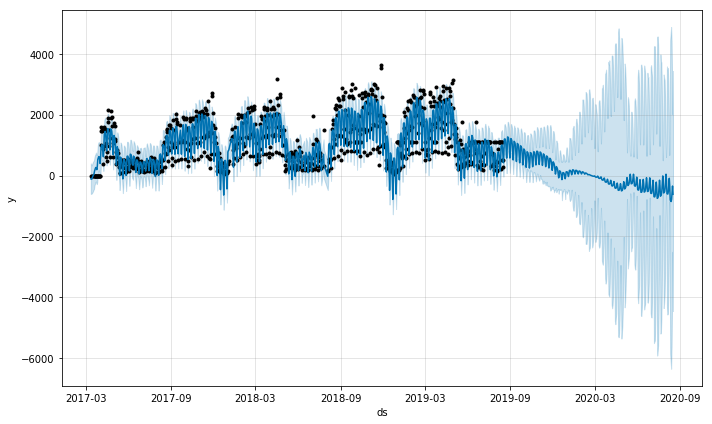

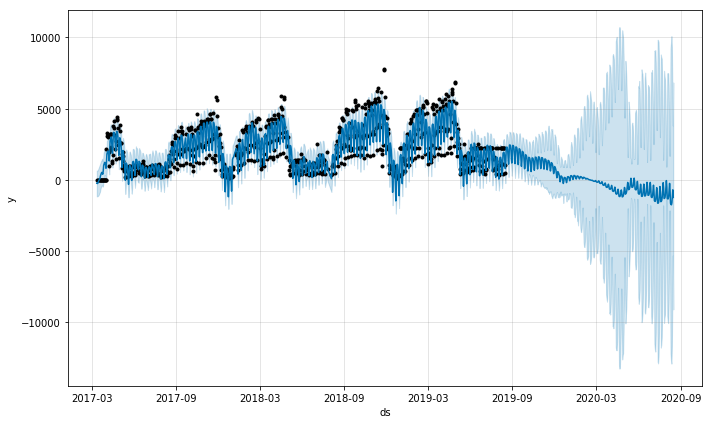

In [37]:
prediction = send_prediction(five_att)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


MAPE for google_documents_created predictions


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00


MAPE for google_documents_edited predictions


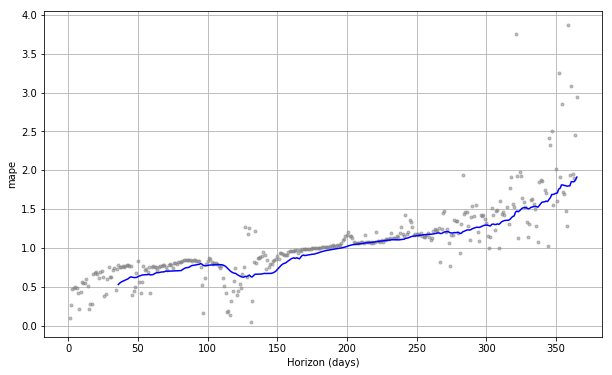

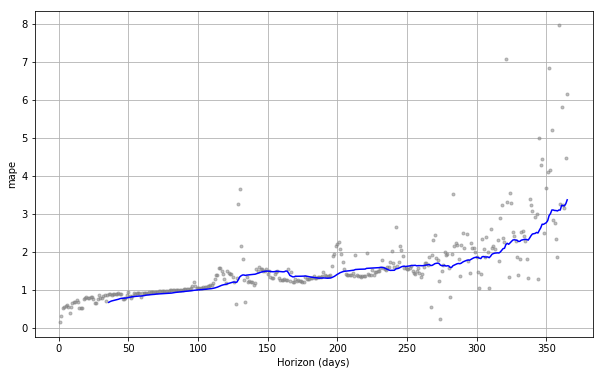

In [38]:
prediction1 = send_predictionMAPE(five_att)